Importa os modulos necessários para execução do script. Como de costume, utilizamos apenas o numpy para cálculos e matplotlib para visualização.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A célula abaixo define as funções necessárias para a execução da simulação do diagrama de olho. Três são as funções principais utilizadas: sigPart(), getMask() e getSignal().

In [2]:
def sigPart(xt, T, N, partInd):
    sigStart = 2*T*N  # ignore some transient effects at the beginning of the signal
    samples_perT = N*T
    samples_perWindow = 2*T*N+1

    sig_part = xt[sigStart + samples_perT*partInd + np.arange(samples_perWindow)]
    t_emphasize = np.linspace(2*T+T*partInd, 2*T+T*partInd+2*T, 2*T*N+1) + t.min()
    
    return t_emphasize, sig_part
    
def getMask(name, T, rollOff=0.5):
    def rc(t, beta):
        return np.sinc(t)*np.cos(np.pi*beta*t)/(1-(2*beta*t)**2)
    def rrc(t, beta):
        return ( np.sin( np.pi*t*(1-beta) ) + 4*beta*t*np.cos(np.pi*t* (1+beta) ) ) / ( np.pi*t*( 1-( 4*beta*t )**2 ) )
    
    if name == 'rc':
        return lambda t: rc(t/T, rollOff)
    elif name == 'rrc':
        return lambda t: rrc(t/T, rollOff)

def setSignal(g, d, T, N):
    # t = np.linspace(-T, (len(d)+2)*T, N)
    t = np.arange(-2*T, (len(d)+2)*T, 1/N)
    g0 = g(np.array([1e-8]))
    xt = sum(d[k]*g(t-k*T) for k in range(len(d)))
    return t, xt/g0

In [24]:
def multiPathChannel(sig, t, T):
    r = np.array([0.1, 0.2])
    p = np.array([np.pi/10, np.pi/15])
    Tt = np.array([T*2, T*3])

    yt = np.zeros(np.shape(sig), dtype=complex)
    for k in range(len(sig)):
        yt[k] = sig[k] + sig[k-int(Tt[0]*N)]*r[0]*np.exp(1j*p[0]) + sig[k-int(Tt[1]*N)]*r[1]*np.exp(1j*p[1])

    return np.array(yt)

Visualização das máscaras aplicadas nos símbolos associados. As variáveis 

(51,)


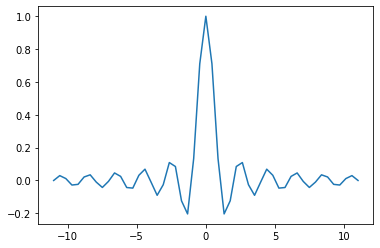

In [4]:
N = 50 # amostragem do tempo

T = 1 # periodo
rollOff = 0 #beta

m = 'rc'

p = 10

t = np.linspace(-(T+p), T+p, N+1)
plt.plot(t,getMask(m, T, rollOff=rollOff)(t))
print(np.shape(t))

Aqui começa a simulação. a variável *sigSize* define o tamanho total do sinal análisado (quantidade de símbolos) para obtenção do diagrama de olho.

**Sugestão**: Iniciar com um quantidade baixa de símbolos para compreensão da simulação, e depois aumentar o número e ver o comportamento do diagrama de olho.

In [27]:
# quantidade de simbolos
sigSize = 10

# cria a variável de dados aleatóriamente (randn) e utiliza a função
# sign para atribuir valores positivos ou negativos à partir de um 
# valor. Dica: help(np.sign) 

r = np.random.randn(sigSize)
data = np.sign(r)

# data = np.array([np.random.randint(0,4) for i in range(sigSize)])

print(data)

[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.]


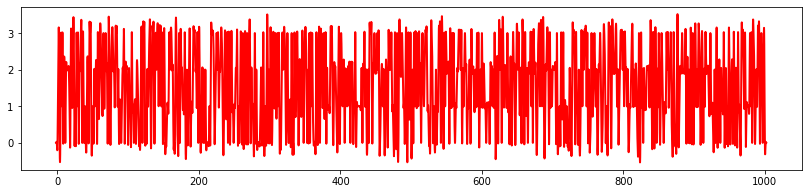

In [6]:
# Cria a mascara para se utilizada, nessa simulação utilizamos dois
# tipos de filtro: Raisec Cosine Filter (RC) e Root Raised Cosine 
# Filter (RRC)
# plot = False
plot = True

T = 1 # periodo
rollOff = 0.6 #beta
m = 'rc'

mask = getMask(m, T=T, rollOff=rollOff)

# Adiciona a máscara ao sinal gerado (data)
t, xt = setSignal(mask, data, T=T, N=N)

# xt = xt + np.array([np.random.randn()*0.2 for i in range(len(t))])
# xt = multiPathChannel(xt, t, T)

if plot:
        fig = plt.figure(figsize=(14,3))
        plt.plot(t, xt, 'r-', lw=2)
        # plt.stem(T*np.arange(len(data)), data, 'b')
        # for k in range(len(data)):
        #         plt.plot(t, data[k]*mask(t-k*T), 'k--', lw=1)

In [7]:
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets

global persistence, eyeParts, eyePartsAlphas

persistence = int(0.8*sigSize)
eyeParts = np.zeros((2*T*N+1, persistence))
eyePartsAlphas = np.logspace(-1, 0, persistence)

def plot_func(part):
    fig, ax = plt.subplots(figsize=(10, 6))

    # plt.subplot(211)
    # plt.plot(t, xt.real, 'k-', lw=2)
    # tt, xtt = sigPart(xt, T, N, part)
    # plt.plot(tt, xtt.real, 'r-', lw=4)
    # plt.xlim([0, t[-1]])

    plt.subplot(235)
    tt, xtt = sigPart(xt.real, T, N, part)
    t_part = np.linspace(-T, T, 2*T*N+1)
    eyeParts[:,:-1] = eyeParts[:,1:]
    eyeParts[:,-1] = xtt.T

# Gera o diagrama de olho a partir do sinal data + mascara
    rgba_colors = np.zeros((persistence,4))
    rgba_colors[:,0] = 0.0
    rgba_colors[:,1] = 0.0
    rgba_colors[:,2] = 1.0
    rgba_colors[:,3] = eyePartsAlphas
    for i in range(0,persistence):
        plt.plot(t_part, eyeParts[:,i].real, color=rgba_colors[i], lw=1)

    plt.show()

interact(plot_func,
        part = widgets.IntSlider(min=0, max=sigSize, step=1, value=5))

interactive(children=(IntSlider(value=5, description='part', max=1000), Output()), _dom_classes=('widget-inter…

<function __main__.plot_func>

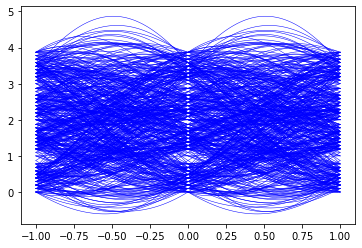

In [25]:
sigSize = 500

data = np.array([np.random.randint(0,4) for i in range(sigSize)])
T = 1 # periodo
rollOff = 0.2 #beta
m = 'rc'

mask = getMask(m, T=T, rollOff=rollOff)
t, xt = setSignal(mask, data, T=T, N=N)

# canal AWGN
xt = xt + np.array([np.random.randn()*0.1 for i in range(len(t))])

# Mutipath channel
# xt = multiPathChannel(xt, t, T)

persistence = int(0.8*sigSize)
eyeParts = np.zeros((2*T*N+1, persistence))
eyePartsAlphas = np.logspace(-1, 0, persistence)

for part in range(0, sigSize):
  tt, xtt = sigPart(xt.real, T, N, part)
  t_part = np.linspace(-T, T, 2*T*N+1)
  plt.plot(t_part, xtt.real, 'b', lw=0.5)

plt.show()

Relatório IMRAD

* Resumo
* Introdução
* Método
* Resultados
* Discussão

O template é o de artigos do IEEE disponível [aqui](https://www.ieee.org/conferences/publishing/templates.html).

